In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector

# Load the dataset
df_dataset = pd.read_csv('Family Income and Expenditure.csv')

# Initial features to use
features = [
    "Housing and water Expenditure",
    "Total Household Income", #1
    "Region", #2
    "Agricultural Household indicator", #3
    "Imputed House Rental Value", #4
    "Total Income from Entrepreneurial Acitivites", #5
    "Total Number of Family members", #6
    "Members with age less than 5 year old", #7
    "Members with age 5 - 17 years old",#8
    "Total number of family members employed", #9
    "Type of Building/House", #10
    "Type of Roof",
    "Type of Walls",
    "House Floor Area",
    "House Age",
    "Number of bedrooms",
    "Electricity",
    "Main Source of Water Supply",
    "Number of Television",
    "Number of CD/VCD/DVD",
    "Number of Component/Stereo set",
    "Number of Refrigerator/Freezer",
    "Number of Washing Machine",
    "Number of Airconditioner",
    "Number of Personal Computer"
]

# Drop features that are not in the initial set of features
df = df_dataset.filter(features, axis=1)

# Drop rows with missing values
df.dropna(inplace=True)

# Create feature called "Number of Children"
df['Number of Children'] = df['Members with age less than 5 year old'] + df['Members with age 5 - 17 years old']

# Drop combined features
df = df.drop(['Members with age less than 5 year old', 'Members with age 5 - 17 years old'], axis=1)

In [2]:
# Define the categorical columns
cat_cols = ['Region', 'Type of Building/House', 'Type of Roof', 'Type of Walls', 'Main Source of Water Supply']

# Create an instance of the TargetEncoder
encoder = ce.TargetEncoder(cols=cat_cols)

# Fit and transform the target encoder on the dataframe
df_encoded = encoder.fit_transform(df, df['Housing and water Expenditure'])

# Access the mapping
mapping = encoder.mapping

# Replace the original categorical columns with the target-encoded values
df[cat_cols] = df_encoded[cat_cols]

# Create a dictionary mapping the categorical columns to the target encoding
cat_dict_map = {}
for column in cat_cols:
    cat_dict_map[column] = list(mapping[column])[:-2]

In [3]:
# Split the dataframe into X and y
X = df.drop(['Housing and water Expenditure'], axis=1)
y = df['Housing and water Expenditure']

# Analyze the correlation among the features
threshold = 0.9
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
upper.head()

# Drop columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

if len(to_drop) > 0:
    print(f'Columns to drop: {to_drop}')
    X = X.drop(to_drop, axis=1)
else:
    print('No columns to drop. The features are not highly correlated.')

No columns to drop. The features are not highly correlated.


Linear Regression Model

RMSE: 16748.55618410993
R2: 0.9007468801134528


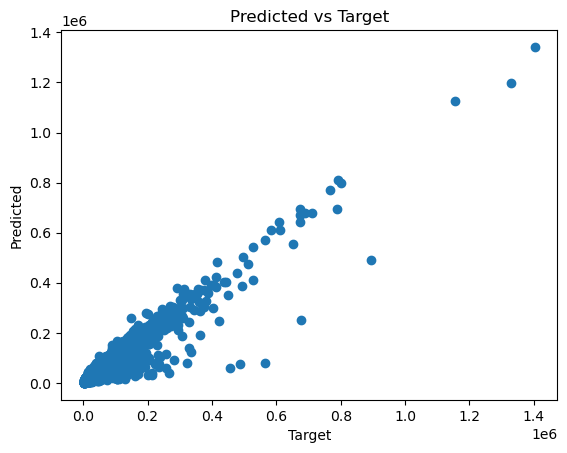

In [4]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Forward feature selection
regressor = LinearRegression()
sfs = SequentialFeatureSelector(regressor, k_features='best', forward=True, scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_train, y_train)

selected_features = list(X_train.columns[list(sfs.k_feature_idx_)])

# Drop features that are not selected
to_drop = [feature for feature in X.columns if feature not in selected_features]
X = X.drop(to_drop, axis=1)

# Fit the model and predict the target
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Show and plot the results
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2: {r2_score(y_test, y_pred)}')

plt.scatter(y_test, y_pred)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.title('Predicted vs Target')
plt.show()

Polynomial Regression Model

RMSE: 16508.000514084146
R2: 0.9035775048495079


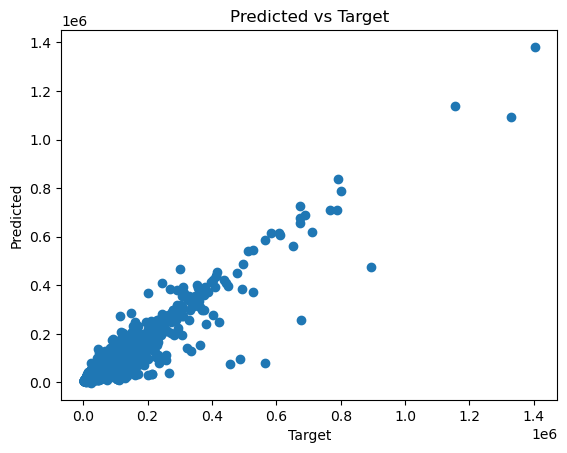

In [5]:
# Account for the interaction between features using a polynomial of degree 2
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X)

# Split the data into train and test sets using X_interactions instead of X
X_train, X_test, y_train, y_test = train_test_split(X_interactions, y, test_size=0.30, random_state=1)

# Fit the model and predict the target
regressor.fit(X_train, y_train)
poly_pred = regressor.predict(X_test)

# Show and plot the results
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, poly_pred))}')
print(f'R2: {r2_score(y_test, poly_pred)}')

plt.scatter(y_test, poly_pred)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.title('Predicted vs Target')
plt.show()

Ridge

Best Alpha: 0.1
RMSE: 16770.981994161048
R2: 0.9004809083186701


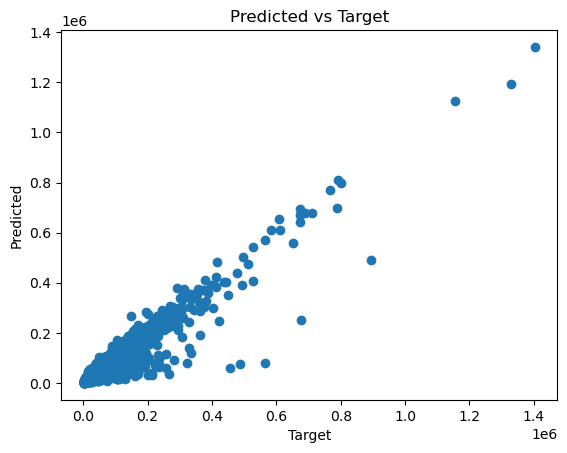

In [6]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

ridge_cv = RidgeCV(cv=5)  # 5-fold cross-validation
ridge_cv.fit(X_train, y_train)
best_alpha_ridge = ridge_cv.alpha_

ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

print(f'Best Alpha: {best_alpha_ridge}')

# Show and plot the results
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}')
print(f'R2: {r2_score(y_test, ridge_pred)}')

plt.scatter(y_test, ridge_pred)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.title('Predicted vs Target')
plt.show()

Lasso

Best Alpha: 0.1
RMSE: 16770.973546952046
R2: 0.9004810085702064


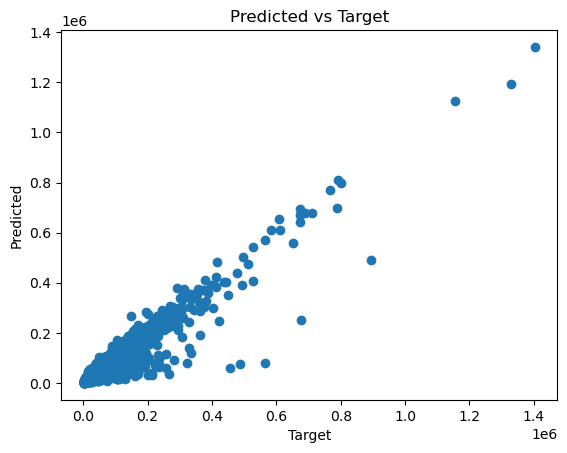

In [7]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

lasso_cv = LassoCV(cv=5)  # 5-fold cross-validation
lasso_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_cv.alpha_

lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

print(f'Best Alpha: {best_alpha_ridge}')

# Show and plot the results
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, lasso_pred))}')
print(f'R2: {r2_score(y_test, lasso_pred)}')

plt.scatter(y_test, lasso_pred)
plt.xlabel('Target')
plt.ylabel('Predicted')
plt.title('Predicted vs Target')
plt.show()